In [8]:
from Bio.PDB import PDBParser
import time
import scipy
import time
import scipy.spatial
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [9]:
'''Supplementary functions'''

def extract_pdb_info(pdb_file_path):
    """
    Reads a PDB file and extracts 3D spatial coordinates and amino acids.

    Input: pdb_file_path (str): Path to the PDB file.

    Output:  A list of dictionaries, each containing information about each atom.
    """
    # Create a PDBParser object
    parser = PDBParser(PERMISSIVE=1)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure('protein', pdb_file_path)
    
    # List to hold the extracted information
    atom_info_list = []

    # Extract information from the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        'model_id': model.id,
                        'chain_id': chain.id,
                        'residue_name': residue.resname,
                        'residue_id': residue.id[1],
                        'atom_name': atom.name,
                        'atom_coords': atom.coord.tolist()
                    }
                    atom_info_list.append(atom_info)

    return atom_info_list

def find_nearest_neighbors(data, angstrom):
    """
    Find the n-neighbors closest to the 'CA' atoms in the data using brute force with Euclidean distance.

    Parameters:
    - data: list of dictionaries, each containing atom information
    - angstrom: float, distance threshold for neighbor counting

    Returns:
    - data: list of dictionaries, containing only 'CA' atoms with updated 'neighbour_count' field,
      and without 'model_id', 'atom_name', and 'atom_coords' keys.
    """
    start_time = time.time()

    # Filter data to only include 'CA' atoms in chain_id 'A'
    ca_atoms = [atom for atom in data if atom.get('chain_id') == 'A' and atom['atom_name'] == 'CA']
    ca_coords = np.array([atom['atom_coords'] for atom in ca_atoms])

    # Calculate distances between 'CA' atoms
    distances = scipy.spatial.distance.cdist(ca_coords, ca_coords, 'euclidean')

    # Use 'residue_id' for DataFrame indexing
    residue_ids = [atom.get('residue_id', f"residue_{i}") for i, atom in enumerate(ca_atoms)]
    
    # Convert distance matrix to pandas DataFrame
    distance_df = pd.DataFrame(distances, index=residue_ids, columns=residue_ids)

    # Format distance matrix to 3 decimal places
    distance_df = distance_df.round(3)

    # Print the distance matrix
    print("Distance matrix between CA atoms (formatted to 3 decimal places):")
    print(distance_df)

    # Count neighbors within a distance of 'angstrom' units for each 'CA' atom
    for index, ca_point in enumerate(ca_coords):
        neighbour_count = np.sum((distances[index] <= angstrom) & (distances[index] != 0))
        ca_atoms[index]['neighbour_count'] = neighbour_count

    # Remove specified keys from the 'CA' atoms
    keys_to_remove = ['model_id', 'atom_name', 'atom_coords']
    for atom in ca_atoms:
        for key in keys_to_remove:
            atom.pop(key, None)

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Elapsed time: {elapsed:.2f} seconds")

    return ca_atoms

def extract_conservation_score(filename):
    result = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                # Skip header lines and lines below confidence cut-off
                if re.match(r'\s*\d+', line):
                    columns = line.split()
                    pos = int(columns[0])
                    score = float(columns[3])

                    # Check if there is a 3LATOM value, otherwise continue
                    if len(columns) > 6 and ':' in columns[2]:
                        residue_id = re.findall(r'\d+', columns[2])[0]  # Extract numbers from the string
                        residue_id = int(residue_id)  # Convert extracted string to integer
                        residue_name = re.findall(r'[A-Za-z]+', columns[2])[0]  # Extract letters from the string
                        result.append({'residue_id': residue_id, 'residue_name': residue_name, 'conservation_score': score})

        return result
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None

def merge_residue_data(conservation_scores, neighbour_counts):
    # Create a dictionary to index the neighbour_counts by residue_id and residue_name
    neighbour_dict = {(item['residue_id'], item['residue_name']): item for item in neighbour_counts}
    
    # List to hold merged data
    merged_data = []
    
    # Merge data from conservation_scores with neighbour_counts
    for score_entry in conservation_scores:
        residue_id = score_entry['residue_id']
        residue_name = score_entry['residue_name']
        
        # Find the corresponding entry in neighbour_counts
        neighbour_entry = neighbour_dict.get((residue_id, residue_name))
        
        if neighbour_entry:
            # Merge the two entries
            merged_entry = {
                'residue_id': residue_id,
                'residue_name': residue_name,
                'conservation_score': score_entry['conservation_score'],
                'neighbour_count': neighbour_entry['neighbour_count']
            }
            merged_data.append(merged_entry)
    
    return merged_data

def plot_and_calculate_correlation(data, angstrom, protein_id, num_residues):
    # Extract data for plotting
    residue_ids = [entry['residue_id'] for entry in data]
    neighbour_counts = [entry['neighbour_count'] for entry in data]
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot neighbour counts
    plt.scatter(residue_ids, neighbour_counts, color='green', label='Neighbour Count')
    
    # Check and plot conservation scores if available
    conservation_scores = [entry['conservation_score'] for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
    if conservation_scores:
        valid_entries = [entry for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
        valid_residue_ids = [entry['residue_id'] for entry in valid_entries]
        valid_neighbour_counts = [entry['neighbour_count'] for entry in valid_entries]
        
        plt.scatter(valid_residue_ids, conservation_scores, color='blue', label='Conservation Score')
        
        # Calculate and print the correlation
        if len(valid_residue_ids) == len(conservation_scores):
            correlation = np.corrcoef(conservation_scores, valid_neighbour_counts)[0, 1]
            print(f"Correlation between Conservation Score and Neighbour Count: {correlation}")
        else:
            print("Mismatch in lengths of valid_residue_ids and conservation_scores")
    else:
        print("Conservation scores not found. Plotting only Neighbour Count.")

    plt.xlabel('Residue ID')
    plt.ylabel('Score / Count')
    plt.title(f'{protein_id} Complete: Residue ID vs Conservation Score and Neighbour Count ({angstrom}A)')
    plt.legend()
    
    # Set plot limits for residue IDs
    plt.xlim(0, num_residues)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


In [10]:
def correlation_plot(data, angstrom, protein_id):
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Check and plot conservation scores if available
    conservation_scores = [entry['conservation_score'] for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
    if conservation_scores:
        valid_entries = [entry for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
        valid_residue_ids = [entry['residue_id'] for entry in valid_entries]
        valid_neighbour_counts = [entry['neighbour_count'] for entry in valid_entries]
        
        plt.scatter(conservation_scores, valid_neighbour_counts, color='blue')
        
        # Calculate and print the correlation
        if len(valid_residue_ids) == len(conservation_scores):
            correlation = np.corrcoef(conservation_scores, valid_neighbour_counts)[0, 1]
            print(f"Correlation between Conservation Score and Neighbour Count: {correlation}")

            # Calculate and Plot Regression Line
            m, b = np.polyfit(conservation_scores, valid_neighbour_counts, 1)
            plt.plot(conservation_scores, m*np.array(conservation_scores) + b, color='red', label='Regression Line')
            
            # Calculate R-squared value
            y_pred = m*np.array(conservation_scores) + b
            ss_res = np.sum((valid_neighbour_counts - y_pred) ** 2)
            ss_tot = np.sum((valid_neighbour_counts - np.mean(valid_neighbour_counts)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)
            
            # Display equation and R-squared on plot
            equation_text = f'y = {m:.2f}x + {b:.2f}\n$R^2$ = {r_squared:.2f}'
            plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

        else:
            print("Mismatch in lengths of valid_residue_ids and conservation_scores")
    else:
        print("Conservation scores not found. Plotting only Neighbour Count.")

    plt.xlabel('Conservation Score')
    plt.ylabel('Neighbour Count')
    plt.title(f'{protein_id}: Conservation Score and Neighbour Count ({angstrom}A)')
    plt.legend()
    plt.ylim(0,6)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

In [11]:
import asyncio
import os
import re
from playwright.async_api import async_playwright

def download_conservation_scores(pdb_file_path, chains):
    pattern = r'pdb(\w+)\.pdb'
    pdb_ids = [match.group(1).upper() for file_path in pdb_file_path if (match := re.search(pattern, file_path))]
    print(pdb_ids)
    
    # Ensure the directory for saving files exists
    output_dir = "conservation_scores"
    os.makedirs(output_dir, exist_ok=True)

    async def scrape_consurf(pdb_id, chain):
        url = f"https://consurfdb.tau.ac.il/DB/{pdb_id.upper()}{chain}/{pdb_id.upper()}{chain}_consurf_summary.txt"
        async with async_playwright() as p:
            browser = await p.chromium.launch()
            page = await browser.new_page()
            try:
                await page.goto(url, timeout=60000)  # Increase timeout to 60 seconds
                content = await page.content()  # Get the content of the page
                if "Page not found" in content:
                    print(f"Error: Page not found for {pdb_id} chain {chain}")
                    return None
                else:
                    content = await page.text_content("body")  # Get the text content directly from the body
                    if content and "Page not found" not in content:
                        file_path = f"{output_dir}/{pdb_id}_consurf_summary.txt"
                        with open(file_path, "w") as file:
                            file.write(content)
                        print(f"Summary for {pdb_id} chain {chain} saved successfully at {file_path}.")
                        return content
                    else:
                        print(f"Content for {pdb_id} chain {chain} not found or invalid.")
                        return None
            except Exception as e:
                print(f"Error processing {pdb_id} chain {chain}: {e}")
                return None
            finally:
                await browser.close()

    async def main():
        tasks = []
        for pdb_id in pdb_ids:
            for chain in chains:
                tasks.append(scrape_consurf(pdb_id, chain))
        
        # Run all tasks concurrently and gather their results
        results = await asyncio.gather(*tasks, return_exceptions=True)
        
        for pdb_id, result in zip(pdb_ids, results):
            if isinstance(result, Exception):
                print(f"Error processing {pdb_id}: {result}")
            elif result:
                print(f"Summary for {pdb_id} saved successfully.")
            else:
                print(f"No content saved for {pdb_id}.")

    # Helper function to run the asyncio code in the correct context
    def run_async_code():
        try:
            loop = asyncio.get_running_loop()
            if loop.is_running():
                return loop.create_task(main())
        except RuntimeError:
            return asyncio.run(main())

    run_async_code()

In [12]:
'''Main function'''

def pdb_to_n_neighbour_vector(pdb_file_path, angstrom, protein_id, num_residues):
    
    amino_vector = []
    title = pdb_file_path.split('/')[-1].split('.')[0][3:].upper()

    atom_info_list = extract_pdb_info(pdb_file_path)

    amino_acid_info_count = find_nearest_neighbors(atom_info_list, angstrom)
    
    print(f"Number of Amino Acids: {len(amino_acid_info_count)}")
    conservation_scores = extract_conservation_score(filename=f"{protein_id}_conservation_scores/{title}_consurf_summary.txt")
    print(conservation_scores)

    if conservation_scores is not None:
        merged_residues = merge_residue_data(conservation_scores, amino_acid_info_count)
        print(merged_residues)
        plot_and_calculate_correlation(merged_residues, angstrom, title, num_residues)
    else:
        print("Conservation scores not found, skipping merge_residue_data. Going straight to plotting.")
        merged_residues = amino_acid_info_count
        plot_and_calculate_correlation(merged_residues, angstrom, title, num_residues)

    return merged_residues

def merge_to_ref_seq(ref_seq, completed):
    # Convert ref_seq to dictionary for efficient lookup
    ref_seq_dict = {entry['residue_id']: entry for entry in ref_seq}

    for entry in completed:
        residue_id = entry['residue_id']
        if residue_id in ref_seq_dict:
            ref_seq_entry = ref_seq_dict[residue_id]
            if 'neighbour_count' in entry:
                ref_seq_entry['neighbour_count'] = entry['neighbour_count']
            if 'conservation_score' in entry:
                ref_seq_entry['conservation_score'] = entry['conservation_score']
        else:
            ref_seq_dict[residue_id] = {
                'residue_id': residue_id,
                'residue_name': entry['residue_name'],
                'neighbour_count': entry.get('neighbour_count', 0),
                'conservation_score': entry.get('conservation_score')
            }

    # Convert back to list
    updated_ref_seq = list(ref_seq_dict.values())
    return updated_ref_seq



In [17]:
def plot_conservation_bar(data,num_residues):

    # Limit the data to the specified number of residues
    if num_residues is not None:
        data = data[:num_residues]
    
    # Extract data for plotting
    residue_ids = [entry['residue_id'] for entry in data]
    conservation_scores = [entry.get('conservation_score', 0) for entry in data]
    
    # Normalize hydrophobicity values for color mapping
    norm = mcolors.Normalize(vmin=min(conservation_scores), vmax=max(conservation_scores))
    cmap = plt.cm.coolwarm  # You can choose any colormap you prefer

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 1))

    # Plot a single horizontal bar with segments colored by hydrophobicity
    for i, conservation_score in enumerate(conservation_scores):
        ax.barh(0, 1, left=i, color=cmap(norm(conservation_score)), edgecolor='none', height=1)

    # Add colorbar to reflect hydrophobicity
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Create a new axis for the colorbar above the plot
    cbar_ax = fig.add_axes([0.15, 2.05, 0.7, 0.05])  # [left, bottom, width, height]
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Conservation Score')

    # Set the x-ticks but hide the labels
    ax.set_xticks(np.arange(len(residue_ids)) + 0.5)
    ax.set_xticklabels([])
    ax.set_yticks([])  # Hide y-axis

    # Set labels and title
    ax.set_xlabel('Residue ID')
    ax.set_title('Conservation Score of Amino Acid Sequence')

    plt.tight_layout()
    plt.show()

['1APY', '1APZ', '1AYY', '1P4K', '1P4V', '2GAC', '2GAW', '2GL9', '3LJQ', '4R4Y', '5V2I', '9GAA', '9GAC', '9GAF']
Distance matrix between CA atoms (formatted to 3 decimal places):
        1       2       3       4       5       6       7       8       9    \
1     0.000   3.846   6.159   9.312  12.798  15.737  19.291  22.810  26.261   
2     3.846   0.000   3.831   6.658  10.390  13.304  16.891  20.443  23.788   
3     6.159   3.831   0.000   3.814   7.093  10.472  13.783  17.483  20.691   
4     9.312   6.658   3.814   0.000   3.794   6.757  10.243  13.851  17.160   
5    12.798  10.390   7.093   3.794   0.000   3.819   6.705  10.457  13.609   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
304  21.765  18.044  17.414  14.877  14.742  13.702  14.819  15.964  17.582   
305  21.773  17.935  17.182  15.132  15.049  14.780  15.772  17.358  18.685   
306  19.920  16.098  15.494  14.181  14.602  15.295  16.669  18.906  20.422   
307  18.670  14.958  13.587  12

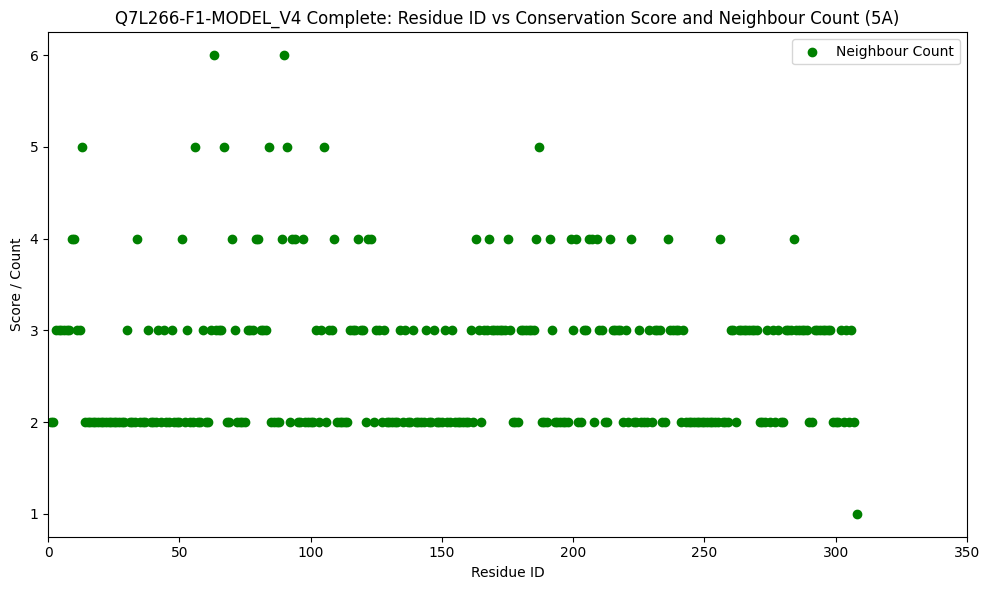

[{'chain_id': 'A', 'residue_name': 'MET', 'residue_id': 1, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'ASN', 'residue_id': 2, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 3, 'neighbour_count': 3}, {'chain_id': 'A', 'residue_name': 'ILE', 'residue_id': 4, 'neighbour_count': 3}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 5, 'neighbour_count': 3}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 6, 'neighbour_count': 3}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 7, 'neighbour_count': 3}, {'chain_id': 'A', 'residue_name': 'HIS', 'residue_id': 8, 'neighbour_count': 3}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 9, 'neighbour_count': 4}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 10, 'neighbour_count': 4}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 11, 'neighbour_count': 3}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 12, 'neighbour_count': 3}, {'chain_id': 'A', 'resid

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5023.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5037.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5051.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5065.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5145.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder

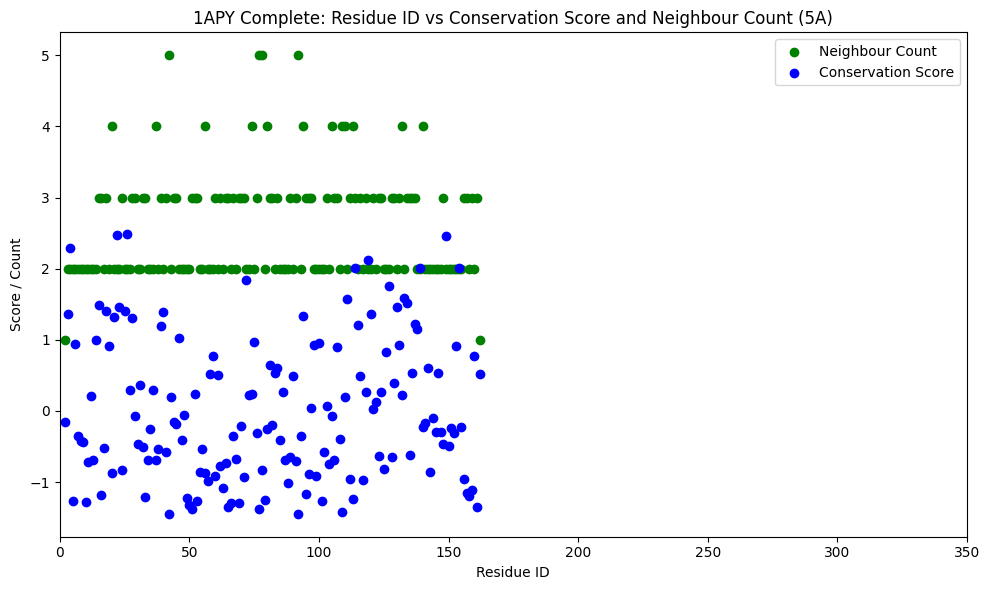

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5046.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5060.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5083.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5097.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5106.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder

Distance matrix between CA atoms (formatted to 3 decimal places):
        2       3       4       5       6       7       8       9       10   \
2     0.000   3.838   6.387   9.028   9.147  12.464  13.730  17.482  20.016   
3     3.838   0.000   3.832   6.487   7.375  10.910  12.992  16.729  19.680   
4     6.387   3.832   0.000   2.940   5.220   8.991  11.830  15.463  18.807   
5     9.028   6.487   2.940   0.000   3.817   7.123  10.502  13.854  17.433   
6     9.147   7.375   5.220   3.817   0.000   3.801   6.769  10.288  13.747   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
158  54.511  54.639  52.896  50.950  47.906  44.474  41.880  38.418  35.794   
159  54.315  54.710  53.100  51.308  48.190  44.878  42.121  38.782  36.024   
160  56.058  56.627  54.976  53.240  50.189  47.005  44.273  41.075  38.391   
161  55.320  56.140  54.598  53.015  49.945  46.920  44.094  41.071  38.346   
162  57.567  58.518  57.158  55.685  52.514  49.516  46.540  43.5

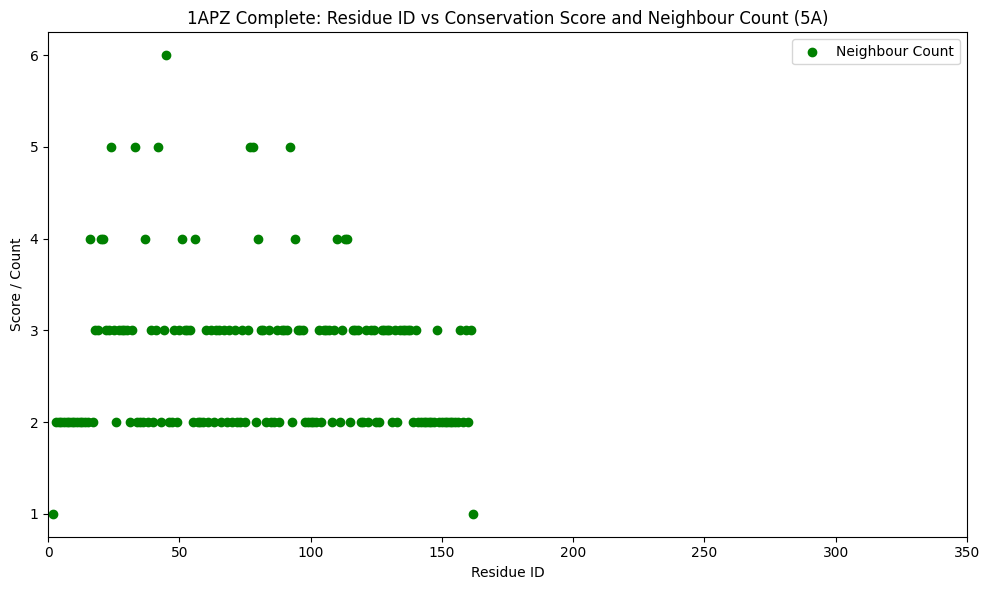

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4710.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4758.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4809.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4858.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        2       3       4       5       6       7       8       9       10   \
2     0.000   3.800   5.935   8.815   9.884  13.276  15.347  19.156  22.042   
3     3.800   0.000   3.799   6.299   6.615  10.129  12.294  16.091  19.060   
4     5.935   3.799   0.000   2.885   5.043   8.697  11.757  15.392  18.804   
5     8.815   6.299   2.885   0.000   3.809   7.051  10.608  13.939  17.567   
6     9.884   6.615   5.043   3.809   0.000   3.809   6.997  10.502  13.988   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
135  48.528  45.616  45.058  43.400  40.150  36.435  33.421  29.690  26.564   
136  51.078  48.269  47.562  45.863  42.719  38.958  36.028  32.295  29.292   
137  53.743  50.872  50.331  48.681  45.438  41.718  38.689  34.969  31.816   
138  52.323  49.544  49.255  47.786  44.412  40.759  37.530  33.912  30.551   
139  50.963  48.332  47.918  46.459  43.173  39.482  36.297  32.7

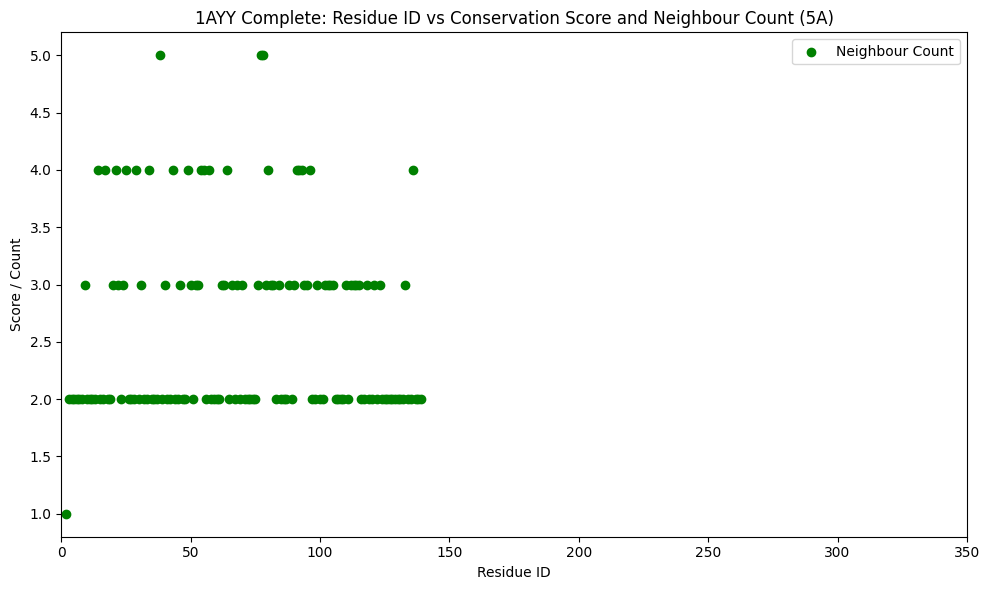

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4964.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4976.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        1       2       3       4       5       6       7       8       9    \
1     0.000   3.819   6.355   9.396  12.303  13.399  16.801  18.679  22.473   
2     3.819   0.000   3.814   6.167   9.035  10.217  13.540  15.665  19.427   
3     6.355   3.814   0.000   3.824   6.480   7.098  10.630  12.859  16.662   
4     9.396   6.167   3.824   0.000   2.912   5.146   8.796  11.880  15.487   
5    12.303   9.035   6.480   2.912   0.000   3.801   7.032  10.589  13.895   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
291  24.906  23.856  22.080  23.817  24.173  20.637  19.333  16.078  16.238   
292  28.201  26.946  25.253  26.737  26.906  23.294  21.551  18.030  17.503   
293  30.382  29.210  27.887  29.461  29.759  26.242  24.515  21.022  20.444   
294  33.828  32.606  31.061  32.490  32.592  28.962  26.976  23.331  22.274   
295  34.473  33.611  32.002  33.728  33.981  30.367  28.664  25.1

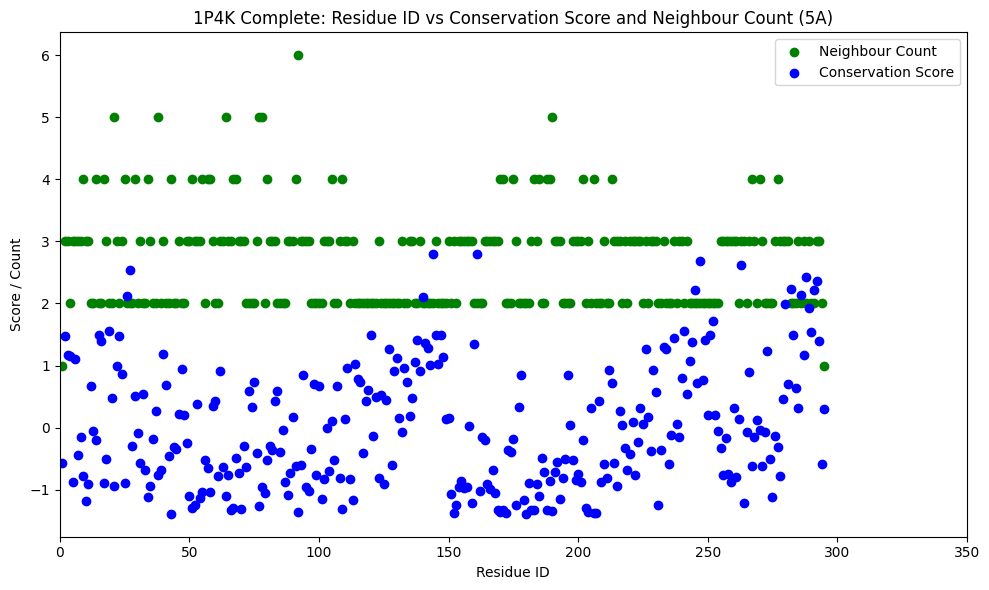

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4931.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4936.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4941.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5035.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        1       2       3       4       5       6       7       8       9    \
1     0.000   3.800   6.550   9.428  12.340  13.460  16.876  18.748  22.518   
2     3.800   0.000   3.809   6.130   9.006  10.098  13.427  15.502  19.240   
3     6.550   3.809   0.000   3.812   6.460   7.003  10.547  12.732  16.504   
4     9.428   6.130   3.812   0.000   2.915   5.098   8.748  11.803  15.366   
5    12.340   9.006   6.460   2.915   0.000   3.798   7.011  10.550  13.797   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
292  28.035  26.456  24.889  26.433  26.677  23.073  21.396  17.893  17.499   
293  30.275  28.823  27.627  29.264  29.642  26.133  24.483  21.014  20.575   
294  33.736  32.210  30.781  32.271  32.444  28.818  26.893  23.263  22.329   
295  34.263  33.068  31.562  33.351  33.671  30.058  28.421  24.881  24.217   
296  34.116  30.809  28.973  27.894  26.463  23.456  19.871  17.0

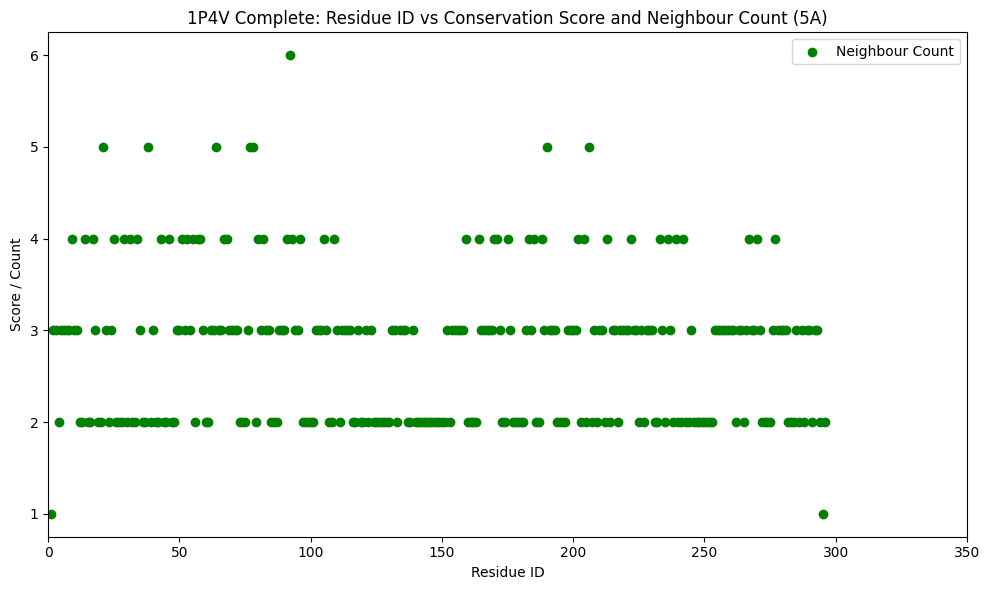

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4714.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4783.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4835.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4906.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        3       4       5       6       7       8       9       10      11   \
3     0.000   3.788   6.484   7.048  10.745  12.819  16.609  19.721  21.995   
4     3.788   0.000   2.964   5.090   8.828  11.771  15.353  18.843  21.333   
5     6.484   2.964   0.000   3.834   7.059  10.550  13.817  17.490  19.938   
6     7.048   5.090   3.834   0.000   3.868   6.902  10.398  13.936  16.342   
7    10.745   8.828   7.059   3.868   0.000   3.826   6.765  10.468  13.029   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
134  47.847  46.512  44.538  41.471  37.689  35.085  31.341  28.339  26.258   
135  46.360  45.124  43.289  40.134  36.348  33.567  29.827  26.675  24.875   
136  49.215  47.838  45.954  42.908  39.084  36.408  32.640  29.606  28.089   
137  51.636  50.398  48.542  45.404  41.615  38.847  35.106  31.947  30.083   
138  49.932  48.937  47.249  43.954  40.235  37.244  33.585  30.2

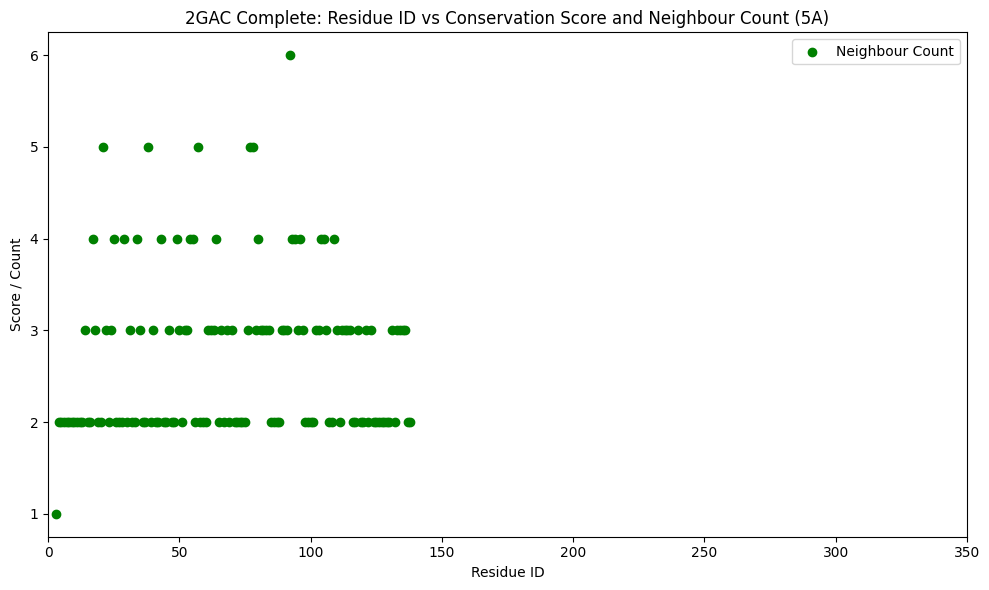

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4708.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4743.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4774.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4808.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        3       4       5       6       7       8       9       10      11   \
3     0.000   3.810   6.501   6.982  10.634  12.739  16.523  19.636  21.863   
4     3.810   0.000   3.007   5.110   8.793  11.769  15.340  18.842  21.287   
5     6.501   3.007   0.000   3.811   6.988  10.504  13.742  17.434  19.821   
6     6.982   5.110   3.811   0.000   3.844   6.907  10.378  13.928  16.268   
7    10.634   8.793   6.988   3.844   0.000   3.822   6.756  10.475  12.999   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
134  47.575  46.339  44.316  41.288  37.551  34.910  31.162  28.143  26.088   
135  46.118  44.977  43.091  39.982  36.230  33.414  29.685  26.513  24.756   
136  49.040  47.751  45.814  42.816  39.020  36.309  32.556  29.502  28.018   
137  51.483  50.350  48.451  45.351  41.599  38.785  35.058  31.870  30.046   
138  49.700  48.813  47.079  43.822  40.140  37.112  33.473  30.0

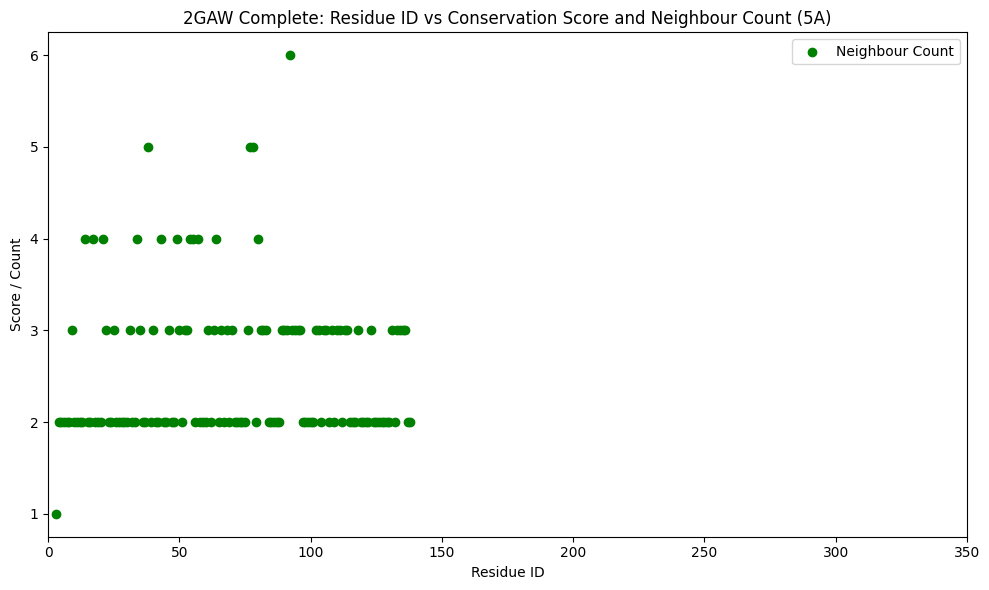

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4840.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4854.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4863.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4892.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4909.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder

Distance matrix between CA atoms (formatted to 3 decimal places):
        2       3       4       5       6       7       8       9       10   \
2     0.000   3.824   5.982   8.796  10.075  13.460  15.646  19.390  22.415   
3     3.824   0.000   3.795   6.362   6.953  10.487  12.720  16.494  19.575   
4     5.982   3.795   0.000   2.840   5.090   8.767  11.874  15.449  18.924   
5     8.796   6.362   2.840   0.000   3.825   7.107  10.690  13.965  17.624   
6    10.075   6.953   5.090   3.825   0.000   3.803   7.019  10.485  14.022   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
137  53.857  51.076  50.099  48.347  45.096  41.365  38.407  34.692  31.516   
138  52.224  49.472  48.753  47.162  43.767  40.097  36.931  33.305  29.924   
139  51.275  48.721  47.981  46.453  43.088  39.394  36.210  32.609  29.242   
140  54.528  52.003  51.119  49.508  46.234  42.500  39.430  35.783  32.530   
141  52.899  50.514  49.470  47.827  44.676  40.918  37.977  34.3

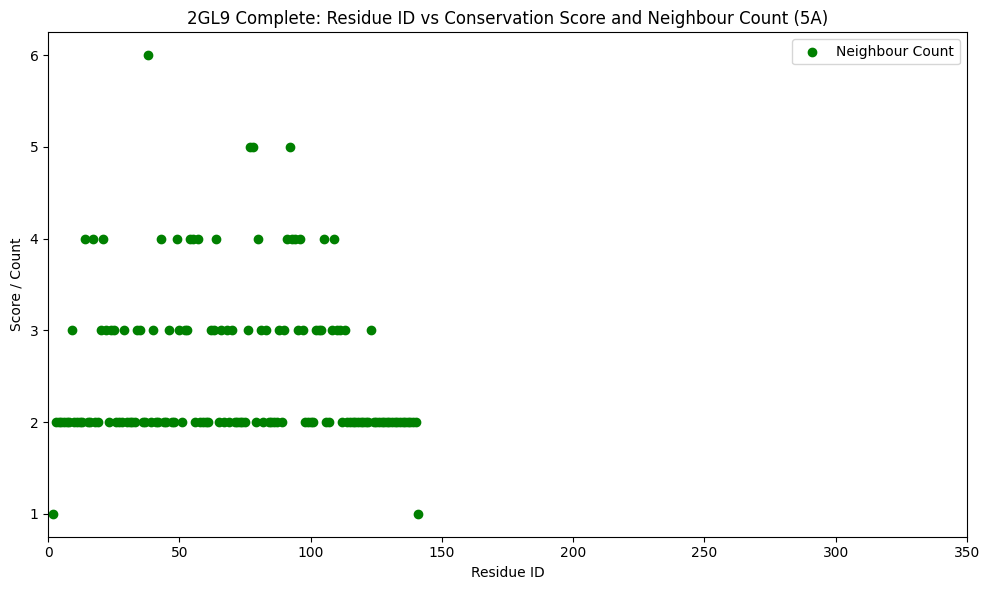

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4851.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4852.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4858.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5105.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        2       3       4       5       6       7       8       9       10   \
2     0.000   3.787   6.079   8.925  10.125  13.500  15.617  19.346  22.382   
3     3.787   0.000   3.828   6.434   7.034  10.608  12.792  16.560  19.653   
4     6.079   3.828   0.000   2.882   5.133   8.783  11.844  15.403  18.887   
5     8.925   6.434   2.882   0.000   3.803   7.008  10.547  13.803  17.463   
6    10.125   7.034   5.133   3.803   0.000   3.810   6.931  10.398  13.924   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
291  23.565  21.709  23.470  23.801  20.256  19.049  15.773  16.019  14.339   
292  26.729  24.975  26.516  26.688  23.075  21.451  17.927  17.516  15.193   
293  29.187  27.776  29.430  29.738  26.213  24.620  21.126  20.666  18.261   
294  32.558  30.928  32.427  32.532  28.893  27.024  23.374  22.428  19.569   
295  33.380  31.632  33.392  33.608  29.976  28.370  24.804  24.0

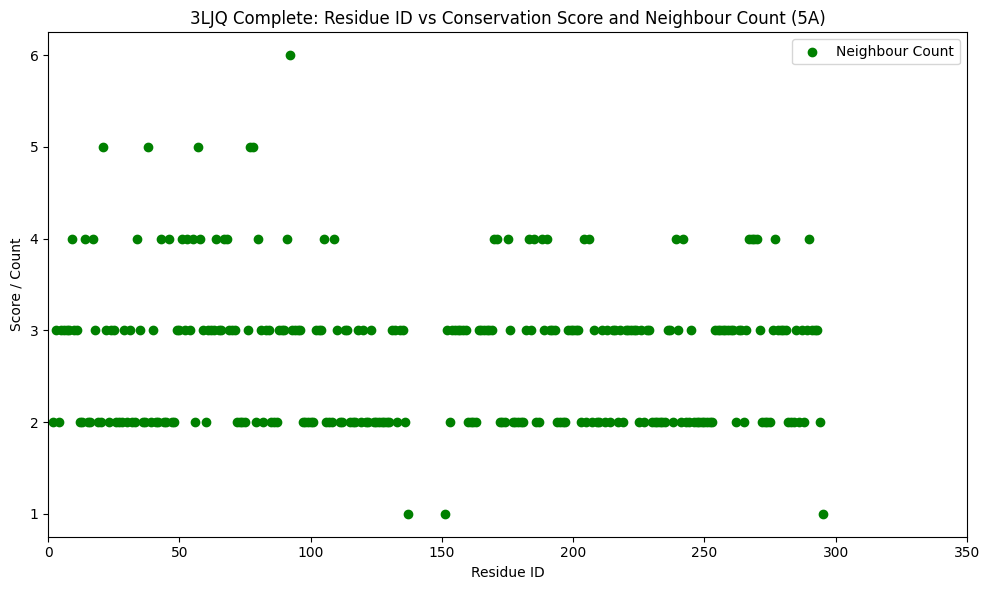

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4766.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4826.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        3       4       5       6       7       8       9       10      11   \
3     0.000   3.822   6.578   7.147  10.689  12.653  16.400  19.694  21.953   
4     3.822   0.000   2.897   5.008   8.678  11.579  15.181  18.813  21.119   
5     6.578   2.897   0.000   3.810   6.972  10.434  13.752  17.526  19.778   
6     7.147   5.008   3.810   0.000   3.783   6.800  10.296  13.971  16.204   
7    10.689   8.678   6.972   3.783   0.000   3.816   6.794  10.593  12.973   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
292  25.150  26.580  26.896  23.270  21.681  18.058  17.288  15.094  15.317   
293  27.773  29.348  29.783  26.254  24.701  21.103  20.304  18.053  18.522   
294  31.054  32.458  32.706  29.064  27.238  23.517  22.250  19.511  19.374   
295  31.754  33.404  33.808  30.176  28.622  24.981  23.976  21.376  20.849   
301  29.225  28.263  26.898  23.761  20.251  17.321  14.026  11.2

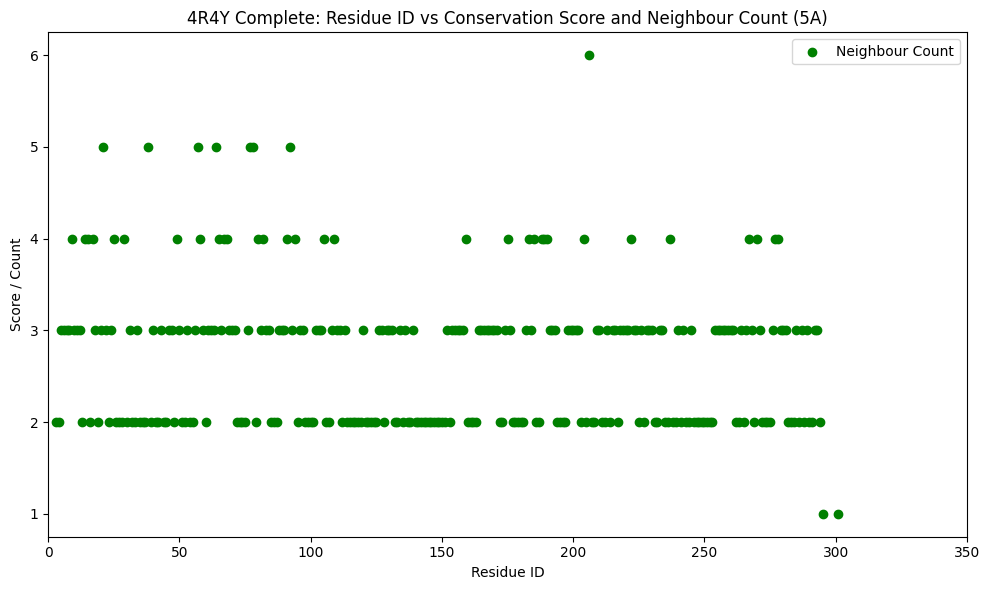

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4719.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4893.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        1       2       3       4       5       6       7       8       9    \
1     0.000   3.833   6.749   9.557  12.440  13.438  16.898  18.639  22.397   
2     3.833   0.000   3.802   6.028   8.896   9.961  13.398  15.408  19.170   
3     6.749   3.802   0.000   3.846   6.470   6.782  10.348  12.416  16.191   
4     9.557   6.028   3.846   0.000   2.889   4.974   8.663  11.650  15.271   
5    12.440   8.896   6.470   2.889   0.000   3.857   7.056  10.562  13.887   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
291  25.101  23.879  21.901  23.837  24.371  20.740  19.443  16.122  16.031   
292  28.365  26.948  25.004  26.656  26.982  23.279  21.525  17.952  17.171   
293  30.631  29.336  27.737  29.440  29.876  26.264  24.516  20.958  20.129   
294  34.045  32.684  30.859  32.442  32.690  28.972  26.969  23.287  21.990   
295  34.548  33.528  31.690  33.596  34.018  30.314  28.612  25.0

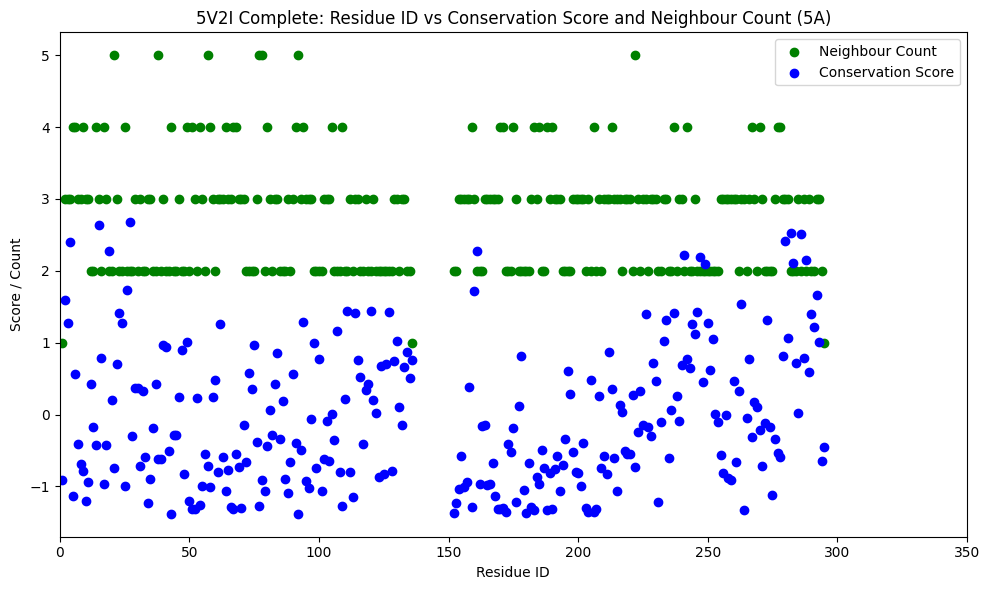

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4780.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4841.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        2       3       4       5       6       7       8       9       10   \
2     0.000   3.796   5.879   8.790   9.958  13.441  15.399  19.107  22.153   
3     3.796   0.000   3.820   6.442   6.968  10.653  12.656  16.424  19.534   
4     5.879   3.820   0.000   2.934   5.110   8.816  11.729  15.301  18.813   
5     8.790   6.442   2.934   0.000   3.803   7.017  10.469  13.745  17.452   
6     9.958   6.968   5.110   3.803   0.000   3.883   6.859  10.349  13.920   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
290  21.666  19.458  20.876  20.988  17.322  15.986  12.563  12.682  11.110   
291  23.283  21.512  23.315  23.763  20.236  19.187  15.857  16.092  14.393   
292  26.491  24.837  26.413  26.709  23.119  21.647  18.095  17.672  15.317   
293  29.139  27.806  29.443  29.852  26.341  24.866  21.330  20.796  18.302   
294  32.554  30.996  32.511  32.721  29.094  27.344  23.667  22.6

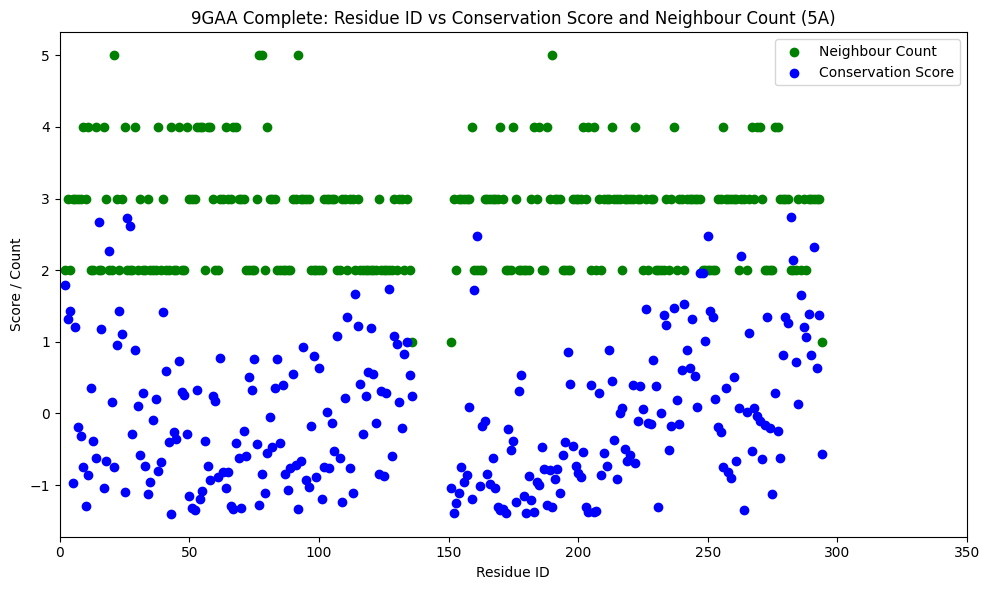

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4802.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4807.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4812.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4888.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        2       3       4       5       6       7       8       9       10   \
2     0.000   3.747   5.799   8.766   9.971  13.484  15.453  19.188  22.251   
3     3.747   0.000   3.898   6.489   7.039  10.723  12.741  16.526  19.643   
4     5.799   3.898   0.000   3.001   5.315   9.025  11.980  15.579  19.095   
5     8.766   6.489   3.001   0.000   3.849   7.076  10.568  13.882  17.579   
6     9.971   7.039   5.315   3.849   0.000   3.874   6.899  10.414  13.984   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
291  23.900  22.047  23.988  24.229  20.634  19.498  16.076  16.122  14.343   
292  27.042  25.276  26.949  27.003  23.330  21.742  18.085  17.436  14.984   
293  29.380  27.966  29.713  29.916  26.336  24.788  21.158  20.469  17.945   
294  32.915  31.308  32.948  32.963  29.280  27.468  23.717  22.577  19.628   
296  31.012  29.198  28.247  26.711  23.633  20.064  17.240  13.9

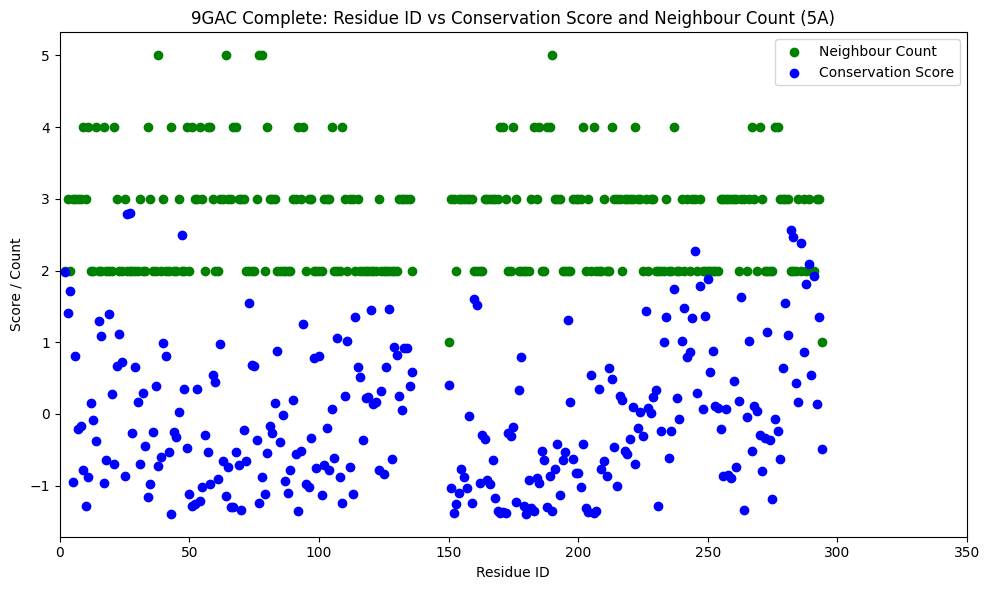

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4954.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4959.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4964.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5071.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        2       3       4       5       6       7       8       9       10   \
2     0.000   3.777   5.944   8.902  10.032  13.360  15.442  19.190  22.163   
3     3.777   0.000   3.858   6.527   7.094  10.646  12.801  16.598  19.624   
4     5.944   3.858   0.000   2.982   5.122   8.766  11.794  15.381  18.820   
5     8.902   6.527   2.982   0.000   3.752   6.991  10.522  13.793  17.428   
6    10.032   7.094   5.122   3.752   0.000   3.815   6.946  10.428  13.923   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
292  27.159  25.490  26.892  27.057  23.461  21.668  18.089  17.509  14.954   
293  29.449  28.134  29.598  29.896  26.384  24.592  21.038  20.394  17.776   
294  32.865  31.338  32.670  32.766  29.153  27.110  23.424  22.313  19.277   
295  33.668  32.062  33.718  33.964  30.369  28.626  25.026  24.219  21.328   
296  30.938  29.249  28.098  26.715  23.707  20.107  17.256  14.0

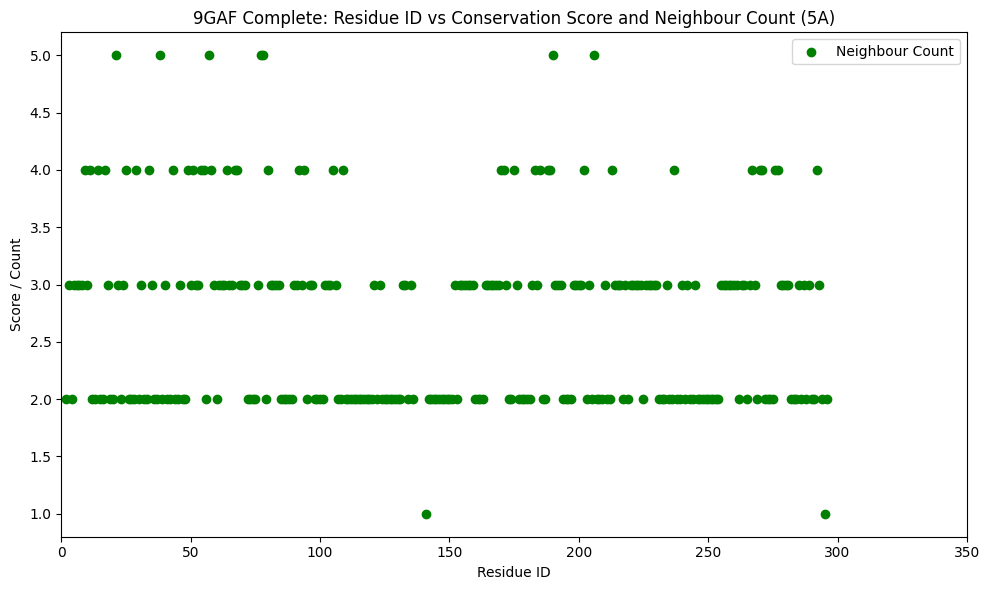

[{'chain_id': 'A', 'residue_name': 'MET', 'residue_id': 1, 'neighbour_count': 1, 'conservation_score': -0.917}, {'chain_id': 'A', 'residue_name': 'ASN', 'residue_id': 2, 'neighbour_count': 2, 'conservation_score': 1.983}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 3, 'neighbour_count': 3, 'conservation_score': 1.403}, {'chain_id': 'A', 'residue_name': 'ILE', 'residue_id': 4, 'neighbour_count': 2, 'conservation_score': 1.716}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 5, 'neighbour_count': 3, 'conservation_score': -0.954}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 6, 'neighbour_count': 3, 'conservation_score': 0.802}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 7, 'neighbour_count': 3, 'conservation_score': -0.205}, {'chain_id': 'A', 'residue_name': 'HIS', 'residue_id': 8, 'neighbour_count': 3, 'conservation_score': -0.171}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 9, 'neighbour_count': 4, 'conservation_score': -0.781}, {'ch

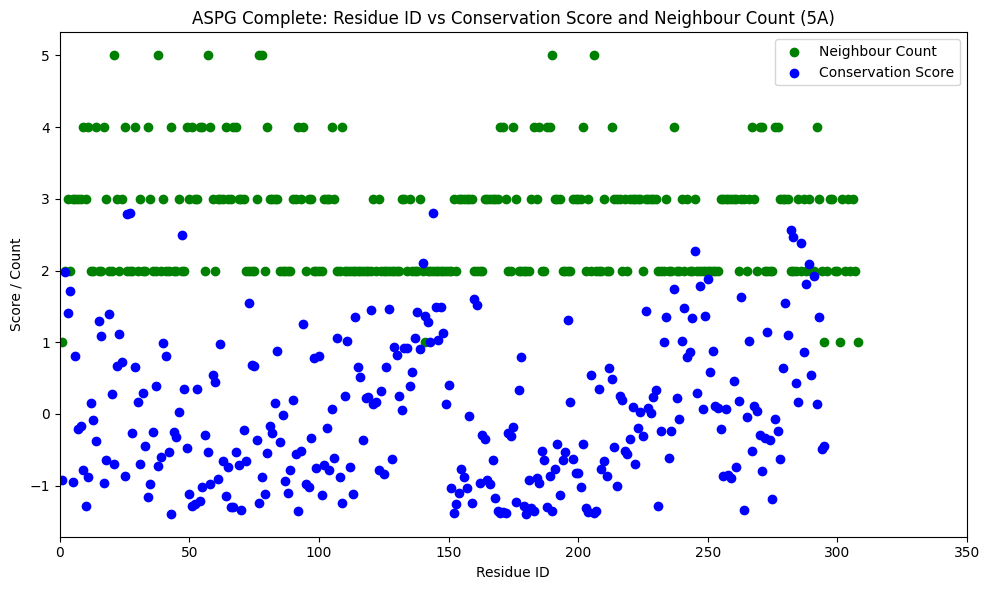

/tmp/ipykernel_17247/3319536817.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


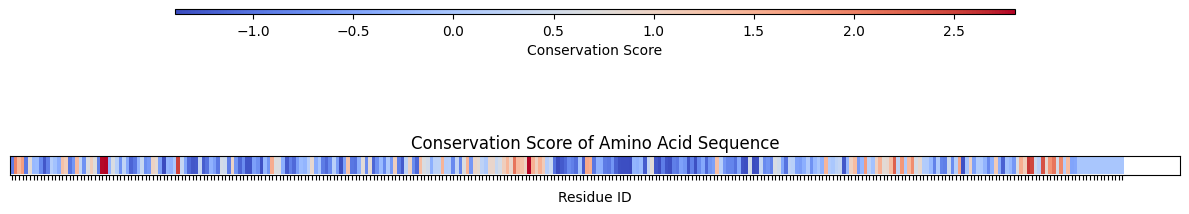

Correlation between Conservation Score and Neighbour Count: -0.37561570329140703


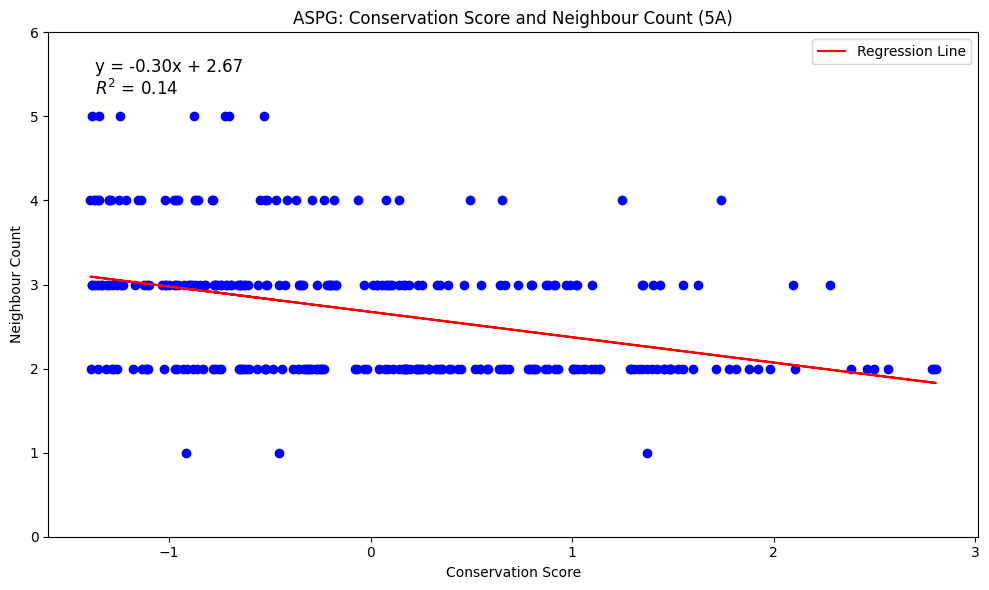

Summary for 1APY chain A saved successfully at conservation_scores/1APY_consurf_summary.txt.
Summary for 2GAC chain A saved successfully at conservation_scores/2GAC_consurf_summary.txt.
Summary for 1APZ chain A saved successfully at conservation_scores/1APZ_consurf_summary.txt.
Summary for 2GAW chain A saved successfully at conservation_scores/2GAW_consurf_summary.txt.
Summary for 1AYY chain A saved successfully at conservation_scores/1AYY_consurf_summary.txt.
Summary for 4R4Y chain A saved successfully at conservation_scores/4R4Y_consurf_summary.txt.
Summary for 3LJQ chain A saved successfully at conservation_scores/3LJQ_consurf_summary.txt.
Summary for 1P4V chain A saved successfully at conservation_scores/1P4V_consurf_summary.txt.
Summary for 2GL9 chain A saved successfully at conservation_scores/2GL9_consurf_summary.txt.
Summary for 5V2I chain A saved successfully at conservation_scores/5V2I_consurf_summary.txt.
Summary for 9GAF chain A saved successfully at conservation_scores/9GA

In [18]:
pdb_file_path = ['./ASPG_pdb/pdb1apy.pdb', './ASPG_pdb/pdb1apz.pdb', './ASPG_pdb/pdb1ayy.pdb', './ASPG_pdb/pdb1p4k.pdb', './ASPG_pdb/pdb1p4v.pdb', './ASPG_pdb/pdb2gac.pdb', './ASPG_pdb/pdb2gaw.pdb', './ASPG_pdb/pdb2gl9.pdb', './ASPG_pdb/pdb3ljq.pdb', './ASPG_pdb/pdb4r4y.pdb', './ASPG_pdb/pdb5v2i.pdb', './ASPG_pdb/pdb9gaa.pdb', './ASPG_pdb/pdb9gac.pdb', './ASPG_pdb/pdb9gaf.pdb']

download_conservation_scores(pdb_file_path, chains = ['A'])

ref_seq = './ASPG_pdb/AF-Q7L266-F1-model_v4.pdb'
ref_seq = pdb_to_n_neighbour_vector(ref_seq, angstrom = 5, protein_id = 'ASPG', num_residues = 350)
print(ref_seq)

for pdb_file in pdb_file_path:
        completed = pdb_to_n_neighbour_vector(pdb_file, angstrom = 5, protein_id = 'ASPG', num_residues = 350)
        updated_ref_seq = merge_to_ref_seq(ref_seq, completed)

print(updated_ref_seq)
plot_and_calculate_correlation(updated_ref_seq, angstrom = 5, protein_id = "ASPG", num_residues = 350)
plot_conservation_bar(updated_ref_seq, num_residues = 350)
correlation_plot(updated_ref_seq, angstrom = 5, protein_id='ASPG')

